In [1]:
this_notebook_name = "SagittalSpineSegmentationStudy-TF2"

# Update this folder name for your computer

local_data_folder = r"c:\Data\SagittalSpineSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 500
batch_size = 128
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 8
class_weights = np.array([0.1, 0.9])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

'''
Provide NxM numpy array to schedule cross validation
N rounds of validation will be performed, leaving out M patients in each for validation data
All values should be valid patient IDs, or negative. Negative values are ignored.

Example 1: a leave-one-out cross validation with 3 patients would look like this:
validation_schedule_patient = np.array([[0],[1],[2]])

Example 2: a leave-two-out cross validation on 10 patients would look like this:
validation_schedule_patient = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])

Example 3: leave-one-out cross validation with 3 patients, then training on all available data (no validation):
validation_schedule_patient = np.array([[0],[1],[2],[-1]])
'''
validation_schedule_patient = np.array([[7]])

# Uncomment for faster debugging

roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01, 0.001]
num_epochs = 5

Save timestamp: 2020-03-05_22-52-02


In [2]:
import os
from random import sample
from pathlib import Path

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import ultrasound_batch_generator as generator
import evaluation_metrics

In [3]:
# Getting a clone of AIGT

aigt_folder = Path('aigt')

if aigt_folder.exists():
    print("Updating aigt clone")
    !git -C aigt pull
else:
    print("Cloning aigt")
    !git clone -q https://github.com/SlicerIGT/aigt.git

import aigt.Models.segmentation_unet as unet
import aigt.utils

Updating aigt clone
Updating ba0d080..2a41548
Fast-forward
 README.md                                          |   6 +-
 SlicerExtension/UsAnnotationExport/CMakeLists.txt  |   1 +
 .../SegmentationUNet/CMakeLists.txt                |  31 ++
 .../Resources/Icons/SegmentationUNet.png           | Bin 0 -> 21024 bytes
 .../Resources/UI/SegmentationUNet.ui               | 294 ++++++++++++++++
 .../SegmentationUNet/SegmentationUNet.py           | 384 +++++++++++++++++++++
 .../SegmentationUNet/Testing/CMakeLists.txt        |   1 +
 .../SegmentationUNet/Testing/Python/CMakeLists.txt |   2 +
 .../SagittalSpineSegmentationStudy-TF2.ipynb       | 120 +++----
 .../SagittalSpineSegmentationTest-TF2.ipynb        |  97 ++----
 10 files changed, 811 insertions(+), 125 deletions(-)
 create mode 100644 SlicerExtension/UsAnnotationExport/SegmentationUNet/CMakeLists.txt
 create mode 100644 SlicerExtension/UsAnnotationExport/SegmentationUNet/Resources/Icons/SegmentationUNet.png
 create mode 100644 SlicerE

From https://github.com/SlicerIGT/aigt
   ba0d080..2a41548  master     -> origin/master


In [4]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

queens_df = pd.read_csv("QueensSagittal.csv", sep=',')

frames = [queens_df]
training_df = pd.concat(frames)

display(training_df)

n_training_arrays = training_df.shape[0]

groupby_patients = training_df.groupby('patient_id')
n_patients = len(groupby_patients.groups.keys())

print("Number of training arrays = {}".format(n_training_arrays))
print("Number of patients        = {}".format(n_patients))

,patient_id,ultrasound_id,ultrasound_filename,segmentation_id,segmentation_filename
0,785,5da9e5c0d9e6a3be02d012b4,q000_ultrasound.npy,5da9e5c8d9e6a3be02d012cc,q000_segmentation.npy
1,736,5da9e5c7d9e6a3be02d012c6,q001_ultrasound.npy,5da9e5ccd9e6a3be02d012de,q001_segmentation.npy
2,651,5da9e5c2d9e6a3be02d012b7,q002_ultrasound.npy,5da9e5c9d9e6a3be02d012cf,q002_segmentation.npy
3,463,5da9e5c3d9e6a3be02d012ba,q003_ultrasound.npy,5da9e5cad9e6a3be02d012d2,q003_segmentation.npy
4,608,5da9e5c8d9e6a3be02d012c9,q004_ultrasound.npy,5da9e5cdd9e6a3be02d012e1,q004_segmentation.npy
5,250,5da9e5c5d9e6a3be02d012c0,q005_ultrasound.npy,5da9e5cbd9e6a3be02d012d8,q005_segmentation.npy
6,347,5da9e5c6d9e6a3be02d012c3,q006_ultrasound.npy,5da9e5cbd9e6a3be02d012db,q006_segmentation.npy
7,695,5da9e5c4d9e6a3be02d012bd,q007_ultrasound.npy,5da9e5cad9e6a3be02d012d5,q007_segmentation.npy


Number of training arrays = 8
Number of patients        = 8


In [5]:
# Creating standard folders to save data and logs

data_arrays_fullpath, notebooks_save_fullpath, results_save_fullpath, models_save_fullpath, val_data_fullpath =\
    aigt.utils.create_standard_project_folders(local_data_folder)

In [6]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

# Preparing progress bar

f = IntProgress(min=0, max=n_training_arrays*2)
display(f)

# Downloading files

gclient = girder_client.GirderClient(apiUrl=girder_api_url)

for i in range(n_training_arrays):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_df.iloc[i]['ultrasound_filename'])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_df.iloc[i]['ultrasound_id'], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_df.iloc[i]['segmentation_filename'])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_df.iloc[i]['segmentation_id'], segmentation_fullname)
    f.value = i * 2 + 2

time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=16)


Total download time: 0:00:00.018950


In [7]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_training_arrays * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_training_arrays):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_df.iloc[i]['ultrasound_filename'])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_df.iloc[i]['segmentation_filename'])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=16)


Total time to load from files: 0:00:00.507122


In [8]:
# Concatenate arrays by patients

ultrasound_arrays_by_patients = []
segmentation_arrays_by_patients = []

patient_ids = groupby_patients.groups.keys()

ultrasound_pixel_type = ultrasound_arrays[0].dtype
segmentation_pixel_type = segmentation_arrays[0].dtype

for patient_id in patient_ids:
    patient_ultrasound_array = np.zeros([0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], 1],
                                        dtype=ultrasound_pixel_type)
    
    patient_segmentation_array = np.zeros([0, segmentation_arrays[0].shape[1], segmentation_arrays[0].shape[2], 1],
                                         dtype=segmentation_pixel_type)
    
    # print(len(groupby_patients.groups[patient_id]))

    for i in range(len(groupby_patients.groups[patient_id])):
        array_index = groupby_patients.groups[patient_id][i]
        patient_ultrasound_array = np.concatenate([patient_ultrasound_array, ultrasound_arrays[array_index]])
        patient_segmentation_array = np.concatenate([patient_segmentation_array, segmentation_arrays[array_index]])
    
    ultrasound_arrays_by_patients.append(patient_ultrasound_array)
    segmentation_arrays_by_patients.append(patient_segmentation_array)
    

print()
for i in range(n_patients):
    print("Patient {} has {} ultrasounds and {} segmentations".format(
        i, ultrasound_arrays_by_patients[i].shape[0], segmentation_arrays_by_patients[i].shape[0]))


Patient 0 has 387 ultrasounds and 387 segmentations
Patient 1 has 360 ultrasounds and 360 segmentations
Patient 2 has 453 ultrasounds and 453 segmentations
Patient 3 has 289 ultrasounds and 289 segmentations
Patient 4 has 477 ultrasounds and 477 segmentations
Patient 5 has 446 ultrasounds and 446 segmentations
Patient 6 has 355 ultrasounds and 355 segmentations
Patient 7 has 523 ultrasounds and 523 segmentations


In [9]:
# Prepare validation rounds

if np.max(validation_schedule_patient) > (n_patients - 1):
    raise Exception("Patient ID cannot be greater than {}".format(n_patients - 1))

num_validation_rounds = len(validation_schedule_patient)
print("Planning {} rounds of validation".format(num_validation_rounds))
for i in range(num_validation_rounds):
    print("Validation on patients {} in round {}".format(validation_schedule_patient[i], i))

Planning 1 rounds of validation
Validation on patients [7] in round 0


Timestamp for saved files: 2020-03-05_22-52-02

Training parameters
Number of epochs:    5
Step size maximum:   0.02
Step size decay:     3.998e-05
Batch size:          128
Regularization rate: 0.0001

Saving validation predictions in: c:\Data\SagittalSpineSegmentationStudy\PredictionsValidation
Saving models in:                 c:\Data\SagittalSpineSegmentationStudy\SavedModels

*** Leave-one-out round # 0
    Training on 2767 images, validating on 523 images...


e:\dlenv2\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  Training time: 0:00:50.794363

Total round time:  0:00:56.627144


Total training time:   0:01:02.321713


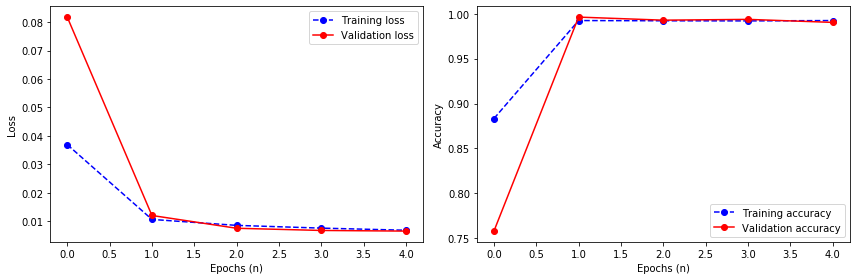

In [10]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for val_round_index in range(num_validation_rounds):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    train_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    val_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    val_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    for patient_index in range(n_patients):
        if patient_index not in validation_schedule_patient[val_round_index]:
            train_ultrasound_data = np.concatenate((train_ultrasound_data,
                                                    ultrasound_arrays_by_patients[patient_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data,
                                                      segmentation_arrays_by_patients[patient_index]))
        else:
            val_ultrasound_data = np.concatenate((val_ultrasound_data,
                                                 ultrasound_arrays_by_patients[patient_index]))
            val_segmentation_data = np.concatenate((val_segmentation_data,
                                                   segmentation_arrays_by_patients[patient_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(val_round_index))
    print("    Training on {} images, validating on {} images...".format(n_train, n_val))
    
    val_segmentation_data_onehot = tf.keras.utils.to_categorical(val_segmentation_data, num_classes)
    
    # Create and train model
    
    model = unet.segmentation_unet(ultrasound_size, num_classes, filter_multiplier, regularization_rate)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
        loss=unet.weighted_categorical_crossentropy(class_weights),
        metrics=["accuracy"]
    )
    
    # model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    if n_val > 0:
        training_log = model.fit_generator(
            training_generator,
            validation_data=(val_ultrasound_data, val_segmentation_data_onehot),
            epochs=num_epochs,
            verbose=0)
    else:
        training_log = model.fit_generator(training_generator, epochs=num_epochs, verbose=0)
    
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    if n_val > 0:
        axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    if n_val > 0:
        axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['accuracy'], 'bo--')
    if n_val > 0:
        axes[1].plot(training_log.history['val_accuracy'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    if n_val > 0:
        axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(val_round_index) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    
    # Predict on validation data
    
    if n_val > 0:
        y_pred_val  = model.predict(val_ultrasound_data)

        # Saving predictions for further evaluation

        val_prediction_filename = save_timestamp + "_prediction_" + str(val_round_index) + ".npy"
        val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
        np.save(val_prediction_fullname, y_pred_val)

        # Validation results

        vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
            roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_fuzzy_metrics[val_round_index] = evaluation_metrics.compute_evaluation_metrics(
            y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_best_metrics[val_round_index]    = vali_metrics_dicts[vali_best_threshold_index]
        val_aurocs[val_round_index]          = vali_area
        val_best_thresholds[val_round_index] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [11]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    if i in val_best_metrics.keys():
        results_df.loc[i] = [
            val_aurocs[i],
            val_best_thresholds[i],
            val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.RECALL],
            val_best_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.RECALL],
            val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
        ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore
0,0.975223,0.1,0.924196,0.040171,0.924196,0.060822,0.59054,0.087039,0.151717



Averages


Vali AUROC           0.975223
Vali best thresh     0.100000
Vali best TP         0.924196
Vali best FP         0.040171
Vali best recall     0.924196
Vali best precis     0.060822
Vali fuzzy recall    0.590540
Vali fuzzy precis    0.087039
Vali fuzzy Fscore    0.151717
dtype: float64

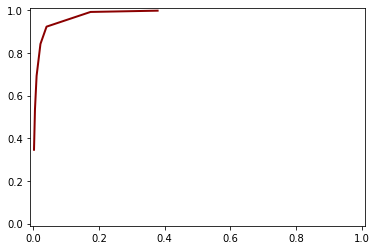

In [12]:
# Print the last ROC curve for visual verification that we catch the optimal point

n = len(roc_thresholds)

roc_x = np.zeros(n)
roc_y = np.zeros(n)

for i in range(n):
    roc_x[i] = vali_metrics_dicts[i][evaluation_metrics.FALSE_POSITIVE_RATE]
    roc_y[i] = vali_metrics_dicts[i][evaluation_metrics.SENSITIVITY]
    # print("Threshold = {0:4.2f}  False pos rate = {1:4.2f}  Sensitivity = {2:4.2f}"
    #       .format(roc_thresholds[i], roc_x[i], roc_y[i]))

    
plt.figure()
plt.ylim(-0.01, 1.01)
plt.xlim(-0.01, 1.01)
plt.plot(roc_x, roc_y, color='darkred', lw=2)

In [13]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: c:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationStudy-TF2_2020-03-05_22-52-02.csv


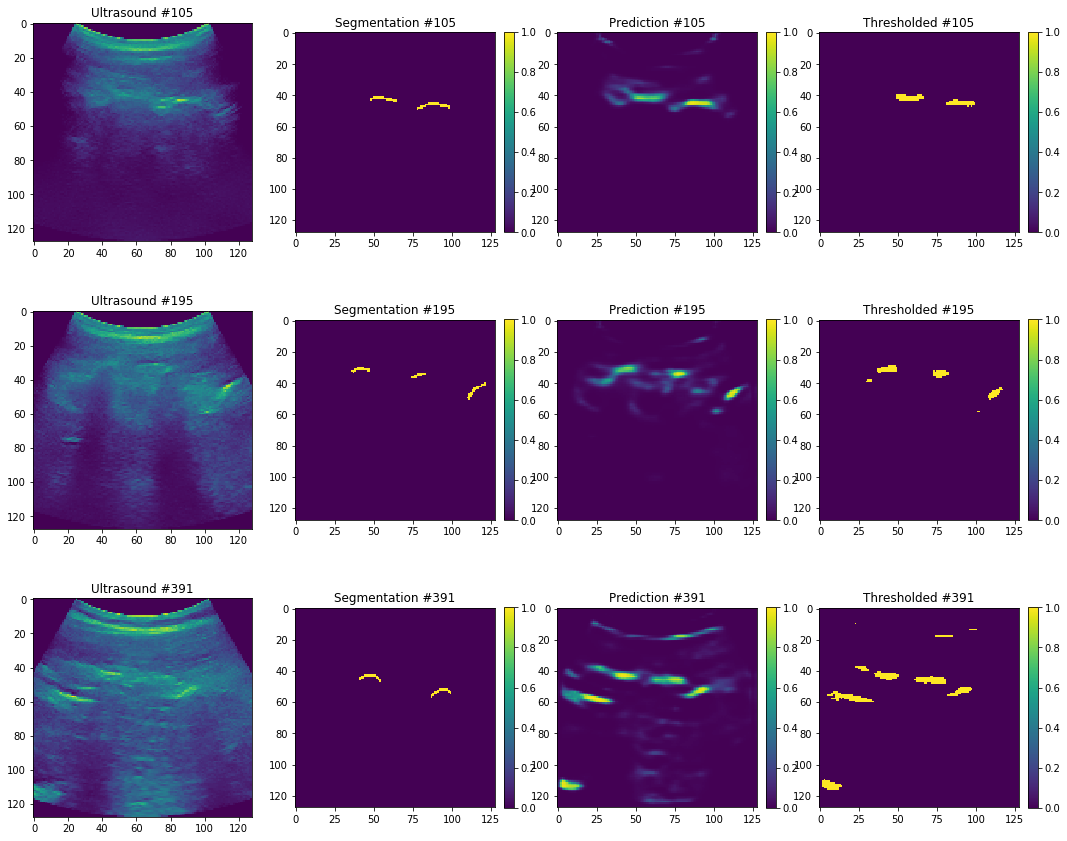

In [14]:
# Display sample results

num_vali = val_ultrasound_data.shape[0]
num_show = 3
if num_vali < num_show:
    num_show = 0
num_col = 4
    
indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)
sample_indices = [105, 195, 391]

threshold = 0.5

# Uncomment for comparing the same images
# sample_indices = [105, 195, 391, 133, 142]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
    img0 = a0.imshow(np.flipud(val_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
    img1 = a1.imshow(np.flipud(val_segmentation_data_onehot[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
    img2 = a2.imshow(np.flipud(y_pred_val[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)
    a3 = fig.add_subplot(num_show, num_col, i*num_col+4)
    img3 = a3.imshow((np.flipud(y_pred_val[sample_indices[i], :, :, 1]) > threshold), vmin=0.0, vmax=1.0)
    c = fig.colorbar(img3, fraction=0.046, pad=0.04)
    a3.set_title("Thresholded #{}".format(sample_indices[i]))

In [15]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [16]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: c:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationStudy-TF2_2020-03-05_22-52-02.html
